In [1]:
#!pip install scanpy
#!pip install scvi-tools
#!pip install leidenalg

In [2]:
# Import libraries and omit warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scanpy as sc
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from anndata import AnnData
import scvi

# Data
The following data brain cell gene count data and metadata from *Tabula Muris* dataset. [Tabula Muris](https://tabula-muris.sf.czbiohub.org/), also known as the "Mouse Atlas," is a comprehensive
collection of single-cell RNA sequencing data from the model organism Mus musculus. It includes nearly 100,000 cells sampled from 20 different organs and tissues. The dataset is carefully controlled
for age, environment, and epigenetic factors, with data obtained from three female and four male mice.

`brain_counts`
- Each row corresponds to a unique single cell. The identifiers in the rows, such as A1.B003290.3_38_F.1.1, represent individual cells with additional metadata encoded in the identifier (e.g., mouse ID, sex, plate barcode).
- Each column represents a gene (e.g., 0610005C13Rik, 0610007C21Rik, etc.). The values in the table are gene expression counts, where each value represents the number of transcripts detected for a given gene in a specific cell.

`brain_meta`

- Each row corresponds to a cell, matching the identifiers in the brain_counts DataFrame.
- cell_ontology_class: The annotated cell type for each cell (e.g., astrocytes, oligodendrocytes).
- subtissue: The specific brain region the cell was isolated from (e.g., Striatum, Cortex).
- mouse.sex: The sex of the mouse from which the cell was taken (M for male, F for female).
- mouse.id: The unique identifier of the mouse (e.g., 3_38_F).
- plate.barcode: The barcode of the plate used during library preparation or sequencing.


In [3]:
"""Read data"""
brain_counts = pd.read_csv('../data/brain_counts.csv', index_col=0)
brain_meta = pd.read_csv('../data/brain_metadata.csv' ,index_col=0)

In [4]:
"""Preview of brain_counts"""
# Message containing number of cells and genes 
msg_counts = f"We have {brain_counts.shape[0]} cells and {brain_counts.shape[1]} genes" 
print(msg_counts)

# First 3 rows
brain_counts.head(3)

We have 3401 cells and 23433 genes


,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,0,195,0,0,113,0


In [5]:
"""Preview of brain_meta"""
# Unique value counts per column
meta_info = brain_meta.nunique()
msg_meta1 = f"We have {brain_meta.shape[0]} cells, classified into {meta_info['cell_ontology_class']} distinct cell types. \n"
msg_meta2 = f"The cells are derived from {meta_info['subtissue']} brain regions, representing {meta_info['mouse.sex']} sexes of mice, \n"  
msg_meta3 = f"sourced from {meta_info['mouse.id']} individuals, and distirbuted across {meta_info['plate.barcode']} barcode plates"
print(msg_meta1 + msg_meta2 + msg_meta3)

# First 3 rows
brain_meta.head(3)

We have 3401 cells, classified into 7 distinct cell types. 
The cells are derived from 4 brain regions, representing 2 sexes of mice, 
sourced from 7 individuals, and distirbuted across 41 barcode plates


,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
cell,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560


# Exploratory Analysis

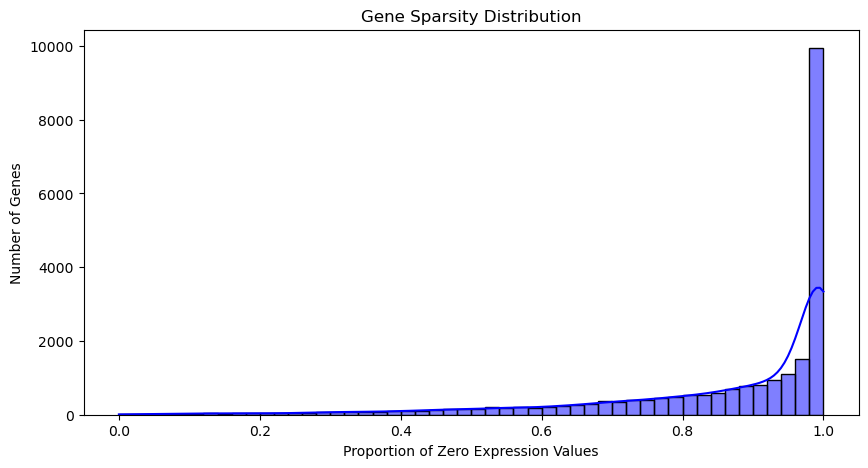

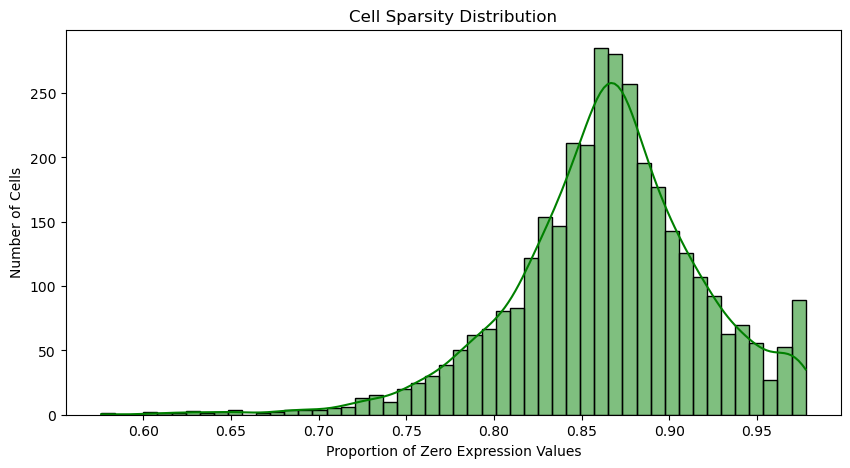

In [6]:
# Calculate sparsity (percentage of zero values)
gene_sparsity = (brain_counts == 0).mean(axis=0)  # Gene-wise
cell_sparsity = (brain_counts == 0).mean(axis=1)  # Cell-wise

# Plot gene sparsity
plt.figure(figsize=(10, 5))
sns.histplot(gene_sparsity, bins=50, kde=True, color='blue')
plt.title('Gene Sparsity Distribution')
plt.xlabel('Proportion of Zero Expression Values')
plt.ylabel('Number of Genes')
plt.show()

# Plot cell sparsity
plt.figure(figsize=(10, 5))
sns.histplot(cell_sparsity, bins=50, kde=True, color='green')
plt.title('Cell Sparsity Distribution')
plt.xlabel('Proportion of Zero Expression Values')
plt.ylabel('Number of Cells')
plt.show()

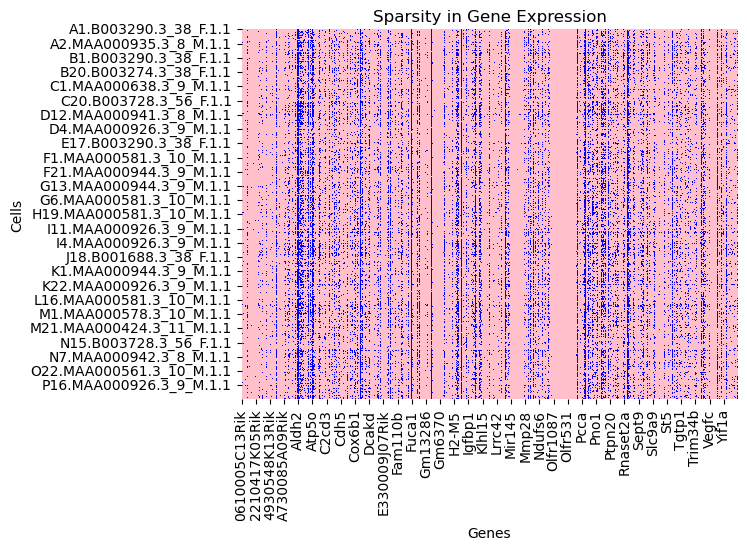

In [7]:
# Define custom colormap
custom_cmap = mcolors.ListedColormap(['blue', 'pink'])

# Heat map. 
# Blue - genes and cell with count equal to zero. 
# Pink - genes and cell with count greater than zero.
sns.heatmap(brain_counts.iloc[::, ::] == 0, cmap=custom_cmap, cbar=False)
plt.title('Sparsity in Gene Expression')
plt.xlabel('Genes')
plt.ylabel('Cells')
plt.show()


# Preprocessing 

For this step, Scanpy will be used, specifically the AnnData method. This will enable better management of the data contained in both the brain counts and the metadata 

-`AnnData.X` stores the count matrix  
-`AnnData.obs` stores metadata about the observations (cells)  
-`AnnData.var` stores metadata about the variables (genes)  
-`AnnData.uns` stores any additional or unstructured informatio 


In [8]:
# Building an AnnData object
adata = sc.AnnData(X = brain_counts, obs = brain_meta)

# We obtain exactly the same number of cells and genes as it was stored in brai_counts
print(adata.shape[0] == brain_counts.shape[0], adata.shape[1] == brain_counts.shape[1])

msg_adata = f"""\n The brain counts are stored in a {type(adata.X)} object, 
the metadata for the observations is stored in a {type(adata.obs)}, 
the metadata for the genes is also stored in a {type(adata.var)}, 
and the aditional information is stored in a {type(adata.uns)}"""

print(msg_adata)

True True

 The brain counts are stored in a <class 'numpy.ndarray'> object, 
the metadata for the observations is stored in a <class 'pandas.core.frame.DataFrame'>, 
the metadata for the genes is also stored in a <class 'pandas.core.frame.DataFrame'>, 
and the aditional information is stored in a <class 'collections.OrderedDict'>


In [9]:
# AnnData - adata.X: stored brain_counts
adata.X

array([[  0, 125,  16, ...,   0,  54,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 348,   0, ...,   0, 113,   0],
       ...,
       [  0, 135,  41, ...,   0,  45,   0],
       [  0, 129,  54, ...,   0,  57,   0],
       [  0,   1,   0, ...,   0,   0,   0]])

In [10]:
# AnnData - adata.obs: stored brain_meta
adata.obs.head(3)

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
cell,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560


In [11]:
# AnnData - adata.var: no annotations yet
adata.var.head(3)

""
0610005C13Rik
0610007C21Rik
0610007L01Rik


In [12]:
# AnnData - adata.uns: empty orderedDict()
adata.uns

OrderedDict()

Because this is smartseq2 data, we may have spike-ins. These gene names start with `ERCC`. We can label them in `adata.var` as a gene annotation.

In [13]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        # Found a spike-in
        is_spike_in[gene_name] = True
        # Add spike-in to the counter
        number_of_spike_ins += 1
    else:
        # Not a spike-in
        is_spike_in[gene_name] = False

# Because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
adata.var['ERCC'] = pd.Series(is_spike_in)

print(f"There are {number_of_spike_ins} spike-ins")

There are 92 spike-ins


In [14]:
# See how adata.var was modified
adata.var.head(3)

,ERCC
0610005C13Rik,False
0610007C21Rik,False
0610007L01Rik,False


In [15]:
# Save AnnData object - adata
adata.write('brain_raw.h5ad')

Now lets add further annotations regarding mitochondrial, riosomal and hemoglobin genes

In [16]:
#ribosomal, mitochondrial
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [17]:
# See how adata.var was modified
adata.var.head(3)

,ERCC,mt,ribo,hb
0610005C13Rik,False,False,False,False
0610007C21Rik,False,False,False,False
0610007L01Rik,False,False,False,False


In [18]:
# Save AnnData object - adata
adata.write('../data/brain_raw.h5ad')

# Quality control

The [scanpy.pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html) function computes various quality control (QC) metrics for single-cell RNA sequencing data, aiding in the assessment of data quality and guiding preprocessing decisions. It will contain a tuple, whose entries were named as it follows:

`cell_qc_dataframe`

It contains the cell level metrics, such as:
- total_counts: Total number of counts (UMIs or reads) per cell.
- log1p_total_counts: Natural logarithm of the total_counts increased by one.
- n_genes_by_counts: Number of genes with non-zero counts in each cell.
- log1p_n_genes_by_counts : Natural logarithm of the n_genes_by_counts increased by one.
- pct_counts_in_top_n_genes: Percentage of counts in the top N most expressed genes, indicating library complexity.
- total_counts_{qc_var}: Total counts for specific gene categories (e.g., mitochondrial genes).
- pct_counts_{qc_var}: Percentage of total counts from specific gene categories.

This dataframe provides insights into individual cell quality, helping identify cells with low library size, high mitochondrial content, other technical anomalies. It's crucial for filtering out low-quality cells that may introduce noise into downstream analyses.

`gene_qc_dataframe`

It contains gene level metrics: 
- total_counts: Sum of counts for each gene across all cells.
- log1p_total_counts: Natural logarithm of the mean_counts increased by one.
- n_cells_by_counts: Number of cells in which each gene is detected.
- log1p_n_genes_by_counts : Natural logarithm of the n_cells_by_count increased by one.
- mean_counts: Average expression level of each gene across all cells.
- log1p_mean_counts: Natural logarithm of the mean_counts increased by one.
- pct_dropout_by_counts: Percentage of cells in which each gene is not detected (zero counts).

Offers information on gene expression patterns across the dataset, identifying genes with low expression and genes with high dropout rates. It helps filter out genes that do not provide meaningful information, thereby reducing dimensionality and focusing on informative features.


By analyzing these QC metrics:
- **Cell-Level QC**: Ensures that only high-quality cells are included in the analysis, avoiding technical artifacts.
- **Gene-Level QC**: Reduces dataset complexity by removing uninformative genes, improving computational efficiency and downstream analysis robustness.


In [19]:
# Generate a tuple of (cell_qc_dataframe, gene_qc_dataframe)
# qc_vars = ['ERCC'] for identifying variables you could want to control (ERCC)
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])

cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

In [20]:
# Cell quality control dataframe
cell_qc_dataframe.head(3)

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_ERCC,log1p_total_counts_ERCC,pct_counts_ERCC
cell,,,,,,,,,,,
A1.B003290.3_38_F.1.1,3359,8.119696,390075,12.874097,25.884766,32.847017,42.219573,59.472666,10201,9.230339,2.615138
A1.B003728.3_56_F.1.1,1718,7.449498,776439,13.562475,43.051933,52.912721,65.313309,87.315423,67351,11.117688,8.674345
A1.MAA000560.3_10_M.1.1,3910,8.271548,1616087,14.295519,44.066006,51.514553,60.164211,74.451190,29870,10.304643,1.848292


In [21]:
# Gene quality control dataframe
gene_qc_dataframe.head(2)

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
0610005C13Rik,28,0.118201,0.111721,99.176713,402,5.998937
0610007C21Rik,2399,206.211996,5.333742,29.461923,701327,13.460731


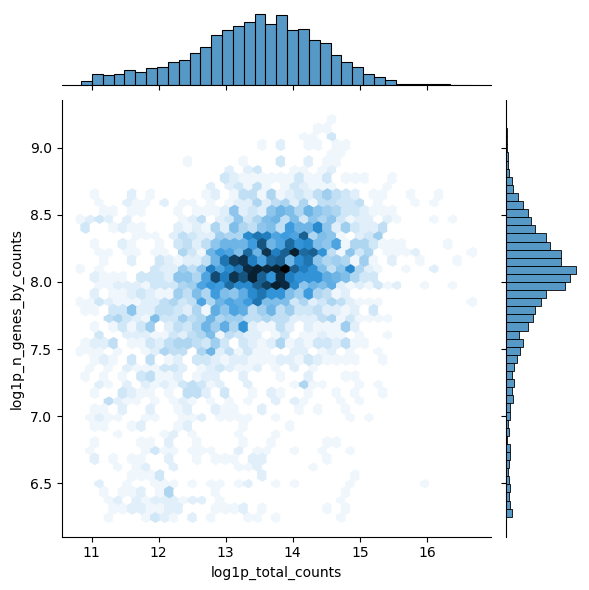

In [22]:
sns.jointplot(
    data=cell_qc_dataframe,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

## Library size
First, we consider the total number of reads detected per cell. Cells with few reads are likely to have been broken or failed to capture a cell, and should thus be removed. In addition to ensuring sufficient sequencing depth for each sample, we also want to make sure that the reads are distributed across the transcriptome. Thus, we count the total number of unique genes detected in each sample.


The threasholds are based on the paper where this data comes,[Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris](https://doi.org/10.1038/s41586-018-0590-4), where: 

- Cells with fewer than 50,000 reads were excluded.
- Cells with fewer than 500 detected genes were excluded. (A gene counts as
detected if it has at least one read mapping to it).

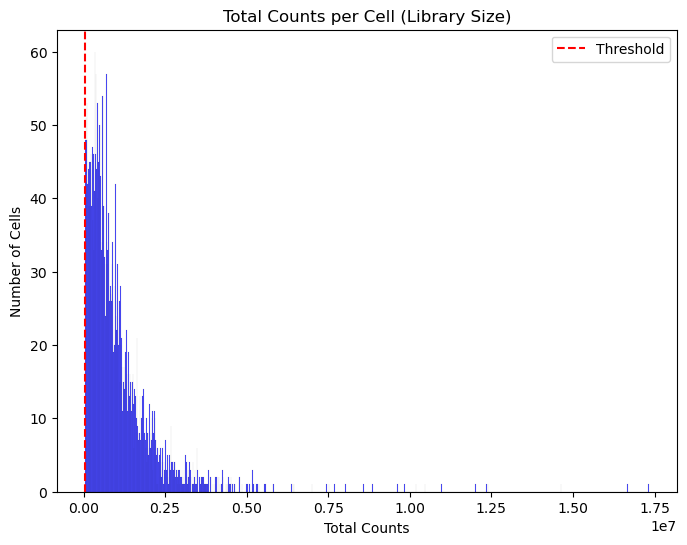

In [23]:
# Library Size (Total Counts per Cell)
plt.figure(figsize=(8, 6))
sns.histplot(cell_qc_dataframe['total_counts'], bins=1000, color='blue', alpha=0.7)
plt.axvline(x=50_000, color='red', linestyle='--', label='Threshold')
plt.title('Total Counts per Cell (Library Size)')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')
plt.legend()
plt.show()

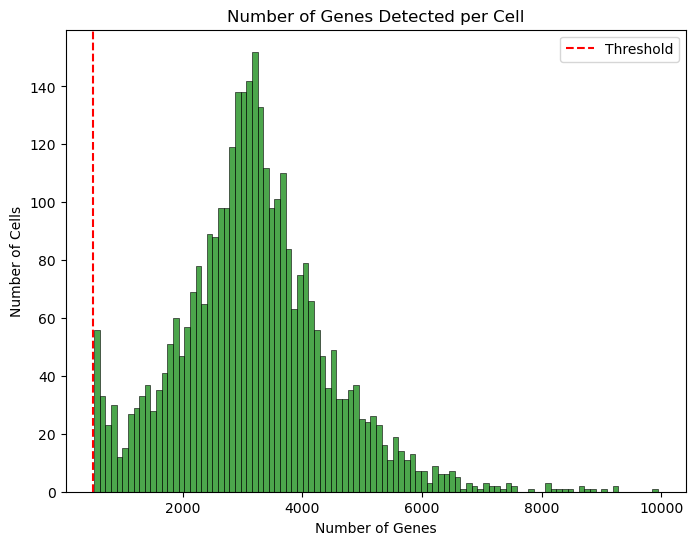

In [24]:
# Detected Genes per Cell
plt.figure(figsize=(8, 6))
sns.histplot(cell_qc_dataframe['n_genes_by_counts'], bins=100, color='green', alpha=0.7)
plt.axvline(x=500, color='red', linestyle='--', label='Threshold')
plt.title('Number of Genes Detected per Cell')
plt.xlabel('Number of Genes')
plt.ylabel('Number of Cells')
plt.legend()
plt.show()

In [25]:
print(f"Cells above 50_000 total counts: {sum(cell_qc_dataframe['total_counts'] > 50_000)} / {len(cell_qc_dataframe)}")
print(f"Cells above 500 detected genes: {sum(cell_qc_dataframe['n_genes_by_counts'] > 500)} / {len(cell_qc_dataframe)}")

Cells above 50_000 total counts: 3401 / 3401
Cells above 500 detected genes: 3401 / 3401


In [26]:
# Filter with scanpy
print('Started with: \n', adata)
sc.pp.filter_cells(adata, min_genes=500)
print('Ended with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC', 'mt', 'ribo', 'hb'
Ended with: 
 AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'mt', 'ribo', 'hb'


All of the cells satified the conditions.

## Spike-ins

Another measure of cell quality is the ratio between ERCC spike-in RNAs and endogenous RNAs. This ratio can be used to estimate the total amount of RNA in the captured cells. Cells with a high level of spike-in RNAs had low starting amounts of RNA, likely due to the cell being dead or stressed which may result in the RNA being degraded.

The 10% threshold is base on the book [Orchestrating Single-Cell Analysis with Bioconductor](https://bioconductor.org/books/3.12/OSCA/)

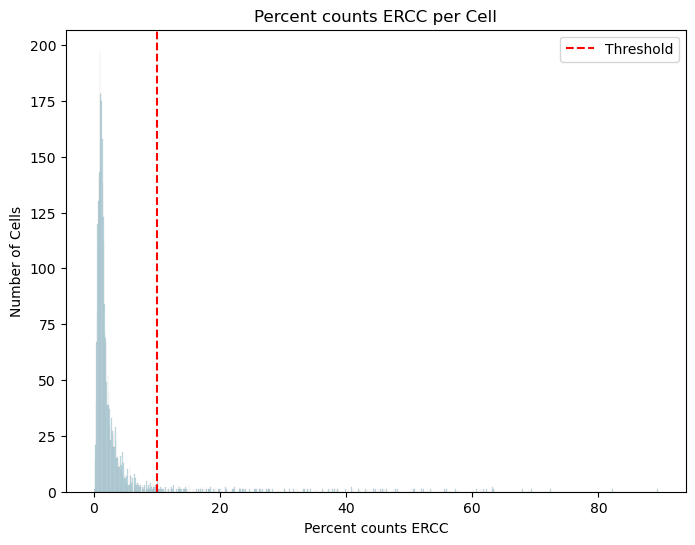

In [27]:
# Detected Genes per Cell
plt.figure(figsize=(8, 6))
sns.histplot(cell_qc_dataframe['pct_counts_ERCC'], bins=1000, color='lightblue', alpha=0.7)
plt.axvline(x=10, color='red', linestyle='--', label='Threshold')
plt.title('Percent counts ERCC per Cell')
plt.xlabel('Percent counts ERCC')
plt.ylabel('Number of Cells')
plt.legend()
plt.show()

In [28]:
print(f"Excluded cells: {sum(cell_qc_dataframe['pct_counts_ERCC'] > 10)}/{len(cell_qc_dataframe)}")
print(f"representing {sum(cell_qc_dataframe['pct_counts_ERCC'] > 10) / len(cell_qc_dataframe) * 100:.2f}%")

Excluded cells: 183/3401
representing 5.38%


In [29]:
# Filter cells with high pct of ERCC manually
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

Notice that we can also obtain the qc metrics for the other genes we previously annotated in the data. 

/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


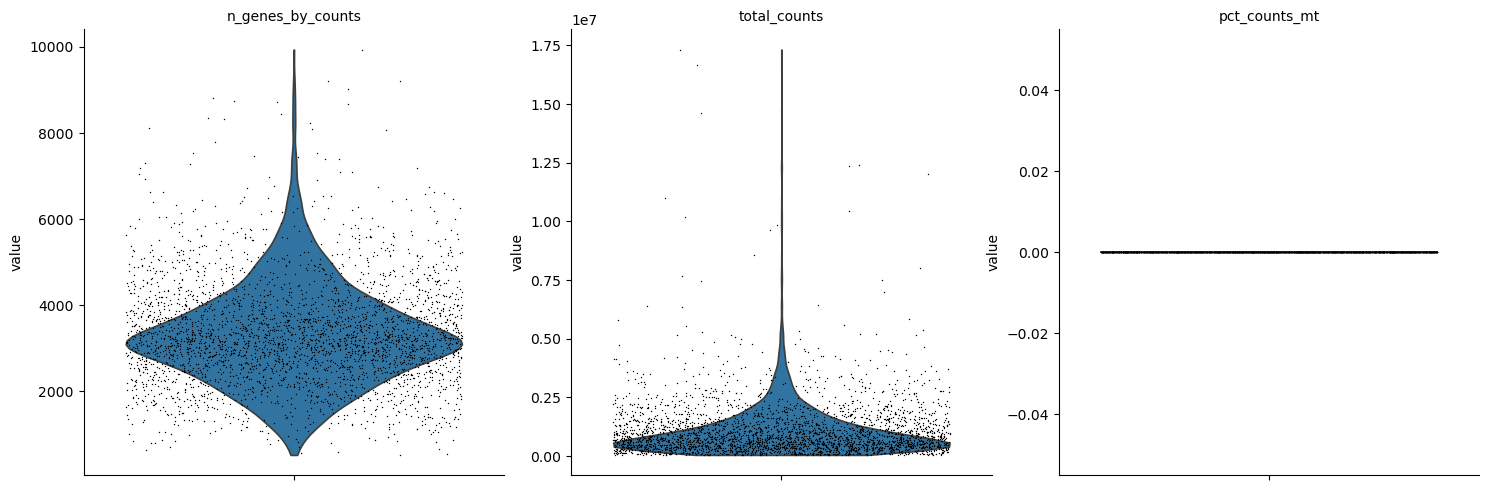

In [30]:
# Metrics for mitochondrial, ribosomal and hemoglobin genes
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

# Plot violin
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

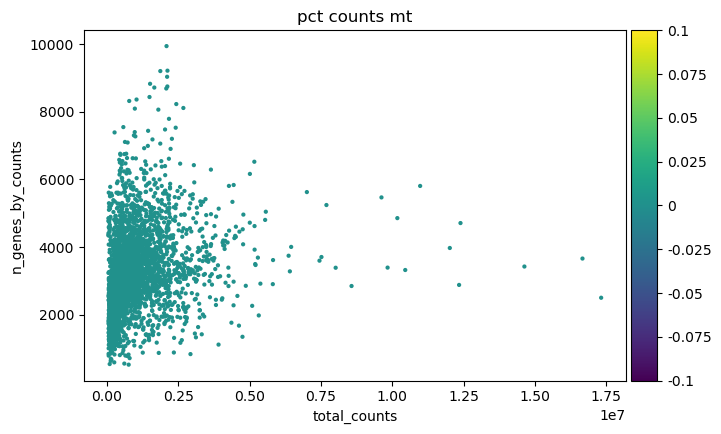

In [31]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Genes

It is typically a good idea to remove genes whose expression level is considered undetectable. We define a gene as  detectable if at least two cells contain more than ten reads from the gene. 

Genes detected in only 1 or 2 cells are often technical noise or artifacts, as true biological expression is unlikely to occur in just one cell in a dataset with thousands of cells.
However, rare cell types or low-expression genes (e.g., transcription factors, signaling molecules) might naturally be detected in a small number of cells.The threshold strongly depends on the sequencing depth. It is important to keep in mind that genes must be filtered after cell filtering since some genes may only be detected in poor quality cells.

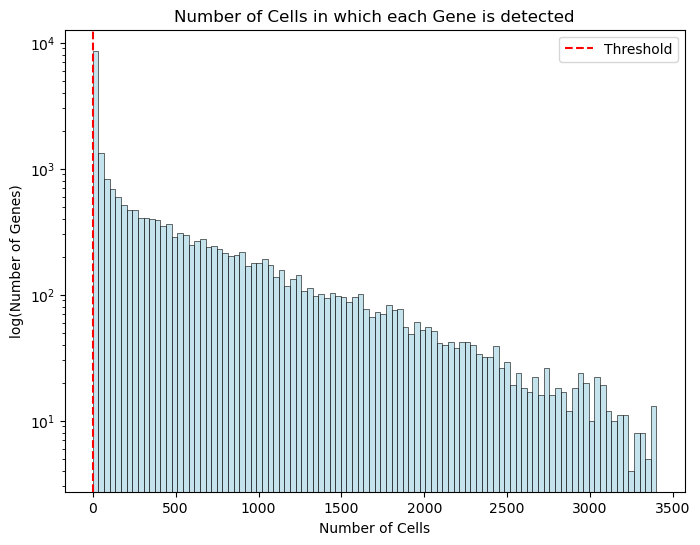

In [32]:
# Plot Number of Cells for each expressed gene
plt.figure(figsize=(8, 6))
sns.histplot(gene_qc_dataframe['n_cells_by_counts'], bins=100, color='lightblue', alpha=0.7)
plt.axvline(x=2, color='red', linestyle='--', label='Threshold')
plt.yscale('log')
plt.title('Number of Cells in which each Gene is detected')
plt.xlabel('Number of Cells')
plt.ylabel('log(Number of Genes)')
plt.legend()
plt.show()

In [33]:
print(f"Excluded genes based on number of cells: {sum(gene_qc_dataframe['n_cells_by_counts'] < 2)}/{len(gene_qc_dataframe)}")
print(f"representing {sum(gene_qc_dataframe['n_cells_by_counts'] < 2) / len(gene_qc_dataframe) * 100:.2f}%")

Excluded genes based on number of cells: 3969/23433
representing 16.94%


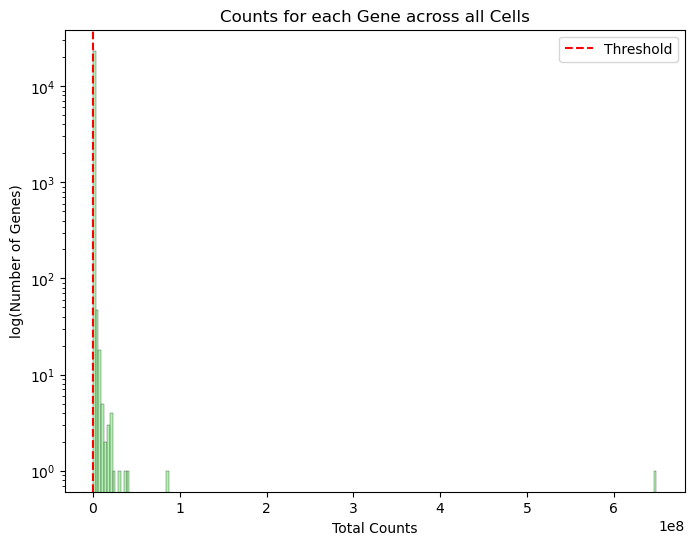

In [34]:
# Plot counts for each Gene across all Cells
plt.figure(figsize=(8, 6))
sns.histplot(gene_qc_dataframe['total_counts'], bins=200, color='lightgreen', alpha=0.7)
plt.axvline(x=10, color='red', linestyle='--', label='Threshold')
plt.title('Counts for each Gene across all Cells')
plt.yscale('log')
plt.xlabel('Total Counts')
plt.ylabel('log(Number of Genes)')
plt.legend()
plt.show()

In [35]:
print(f"Excluded genes based on total counts: {sum(gene_qc_dataframe['total_counts'] < 10)}/{len(gene_qc_dataframe)}")
print(f"representing {sum(gene_qc_dataframe['total_counts'] < 10) / len(gene_qc_dataframe) * 100:.2f}%")

Excluded genes based on total counts: 4432/23433
representing 18.91%


In [36]:
# Filtering with scanpy.pp.filter_genes()
print('Started with: \n', adata)

# Minimum 2 cells
sc.pp.filter_genes(adata, min_cells = 2)
# And a minimum total of 10
sc.pp.filter_genes(adata, min_counts = 10)

print('Finished with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 3218 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'ERCC', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
Finished with: 
 AnnData object with n_obs × n_vars = 3218 × 18590
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'p

In [38]:
# Save data
adata.write('../data/brain_qc.h5ad')